<a href="https://colab.research.google.com/github/dcpatton/keras_tuner/blob/master/keras_tuning_part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import random

seed = 52
tf.random.set_seed(seed)
random.seed(seed)

print('TensorFlow version = ' + tf.__version__)

accuracies = [] # for metric tracking

TensorFlow version = 2.3.0


In [2]:
!pip install keras-tuner -q
import kerastuner as kt
print('Keras Tuner version = ' + kt.__version__)

     |████████████████████████████████| 61kB 4.5MB/s 
Keras Tuner version = 1.0.1


## Load CIFAR10

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# Normalize the data
train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

# Baseline

In [5]:
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Dense
from tensorflow.keras import Input, Model

inp = Input(shape=(32, 32, 3), name='inp')
x = Conv2D(32, 3, activation='elu')(inp)
x = MaxPool2D()(x)
x = Conv2D(64, 3, activation='elu')(x)
x = MaxPool2D()(x)
x = Conv2D(128, 3, activation='elu')(x)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dense(64, activation='swish')(x)
out = Dense(10, activation='softmax')(x)

model = Model(inputs=[inp], outputs=[out])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=['acc'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)        

In [6]:
filepath = 'model.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True)
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

history = model.fit(train_images, train_labels, epochs=200, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[mc, es], verbose=2)

Epoch 1/200
1563/1563 - 7s - loss: 1.3606 - acc: 0.5176 - val_loss: 1.1198 - val_acc: 0.6016
Epoch 2/200
1563/1563 - 6s - loss: 1.0051 - acc: 0.6472 - val_loss: 1.0046 - val_acc: 0.6511
Epoch 3/200
1563/1563 - 6s - loss: 0.8513 - acc: 0.7029 - val_loss: 0.9233 - val_acc: 0.6860
Epoch 4/200
1563/1563 - 6s - loss: 0.7459 - acc: 0.7388 - val_loss: 0.9063 - val_acc: 0.6882
Epoch 5/200
1563/1563 - 6s - loss: 0.6583 - acc: 0.7691 - val_loss: 0.8839 - val_acc: 0.7119
Epoch 6/200
1563/1563 - 6s - loss: 0.5805 - acc: 0.7972 - val_loss: 0.9156 - val_acc: 0.7082
Epoch 7/200
1563/1563 - 6s - loss: 0.5120 - acc: 0.8188 - val_loss: 0.9645 - val_acc: 0.7022
Epoch 8/200
1563/1563 - 6s - loss: 0.4534 - acc: 0.8415 - val_loss: 0.9828 - val_acc: 0.7026
Epoch 9/200
1563/1563 - 6s - loss: 0.4017 - acc: 0.8596 - val_loss: 1.0369 - val_acc: 0.6969
Epoch 10/200
1563/1563 - 6s - loss: 0.3545 - acc: 0.8740 - val_loss: 1.1093 - val_acc: 0.7077
Epoch 11/200
1563/1563 - 6s - loss: 0.3174 - acc: 0.8865 - val_loss: 

In [7]:
model.load_weights(filepath)
metrics = model.evaluate(test_images, test_labels, verbose=0)
print('Loss = ' + str(metrics[0]))
print('Accuracy = ' + str(metrics[1]))
accuracies.append(metrics[1])

Loss = 0.8839487433433533
Accuracy = 0.711899995803833


# Hyperband Tuner

In [8]:
def build_hypermodel(hp):
  inp = Input(shape=(32, 32, 3), name='inp')
  x = Conv2D(hp.Int('f_1', 16, 256, 16), 3, activation='elu')(inp)
  x = MaxPool2D()(x)
  x = Conv2D(hp.Int('f_2', 16, 256, 16), 3, activation='elu')(x)
  x = MaxPool2D()(x)
  x = Conv2D(hp.Int('f_3', 16, 256, 16), 3, activation='elu')(x)
  x = MaxPool2D()(x)
  x = Flatten()(x)
  x = Dense(hp.Int('h_1', 32, 512, 32), activation='swish')(x)
  out = Dense(10, activation='softmax')(x)

  model = Model(inputs=[inp], outputs=[out])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                metrics=['acc'])

  return model

In [9]:
import IPython

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [16]:
# helper function to perform tuning
def tune():

  tuner = kt.Hyperband(hypermodel=build_hypermodel, 
                     objective='val_loss', 
                     max_epochs=100, 
                     factor=3, 
                     hyperband_iterations=1, 
                     directory='test_dir',
                     project_name='a',
                     seed=seed,
                     overwrite=True)
  
  es = tf.keras.callbacks.EarlyStopping(patience=10)
  tuner.search(train_images, train_labels, epochs=200, 
              validation_data=(test_images, test_labels), 
              verbose=0, callbacks=[es, ClearTrainingOutput()])
  
  return tuner

In [17]:
tuner = tune()

INFO:tensorflow:Oracle triggered exit


In [18]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(f"""
The hyperparameter search is complete. The optimal filter sizes are {best_hps.get('f_1')}
, {best_hps.get('f_2')}, and {best_hps.get('f_3')}. The optimal hidden_units is {best_hps.get('h_1')}.
""")


The hyperparameter search is complete. The optimal filter sizes are 32
, 64, and 192. The optimal hidden_units is 352.



In [19]:
def train(model):
  mc = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True)
  es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

  history = model.fit(train_images, train_labels, epochs=200, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[mc, es], verbose=2)
  return history

In [20]:
model = tuner.hypermodel.build(best_hps)

In [21]:
history = train(model)

Epoch 1/200
1563/1563 - 6s - loss: 1.3286 - acc: 0.5280 - val_loss: 1.1246 - val_acc: 0.6066
Epoch 2/200
1563/1563 - 6s - loss: 0.9441 - acc: 0.6680 - val_loss: 0.9304 - val_acc: 0.6785
Epoch 3/200
1563/1563 - 6s - loss: 0.7443 - acc: 0.7395 - val_loss: 0.8568 - val_acc: 0.7118
Epoch 4/200
1563/1563 - 6s - loss: 0.5854 - acc: 0.7961 - val_loss: 0.8667 - val_acc: 0.7222
Epoch 5/200
1563/1563 - 6s - loss: 0.4557 - acc: 0.8419 - val_loss: 0.9430 - val_acc: 0.7131
Epoch 6/200
1563/1563 - 6s - loss: 0.3367 - acc: 0.8826 - val_loss: 1.0370 - val_acc: 0.7184
Epoch 7/200
1563/1563 - 6s - loss: 0.2590 - acc: 0.9089 - val_loss: 1.1939 - val_acc: 0.7044
Epoch 8/200
1563/1563 - 6s - loss: 0.2094 - acc: 0.9271 - val_loss: 1.2643 - val_acc: 0.7136
Epoch 9/200
1563/1563 - 6s - loss: 0.1787 - acc: 0.9381 - val_loss: 1.4173 - val_acc: 0.7081
Epoch 10/200
1563/1563 - 6s - loss: 0.1658 - acc: 0.9425 - val_loss: 1.5155 - val_acc: 0.7136
Epoch 11/200
1563/1563 - 6s - loss: 0.1424 - acc: 0.9519 - val_loss: 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


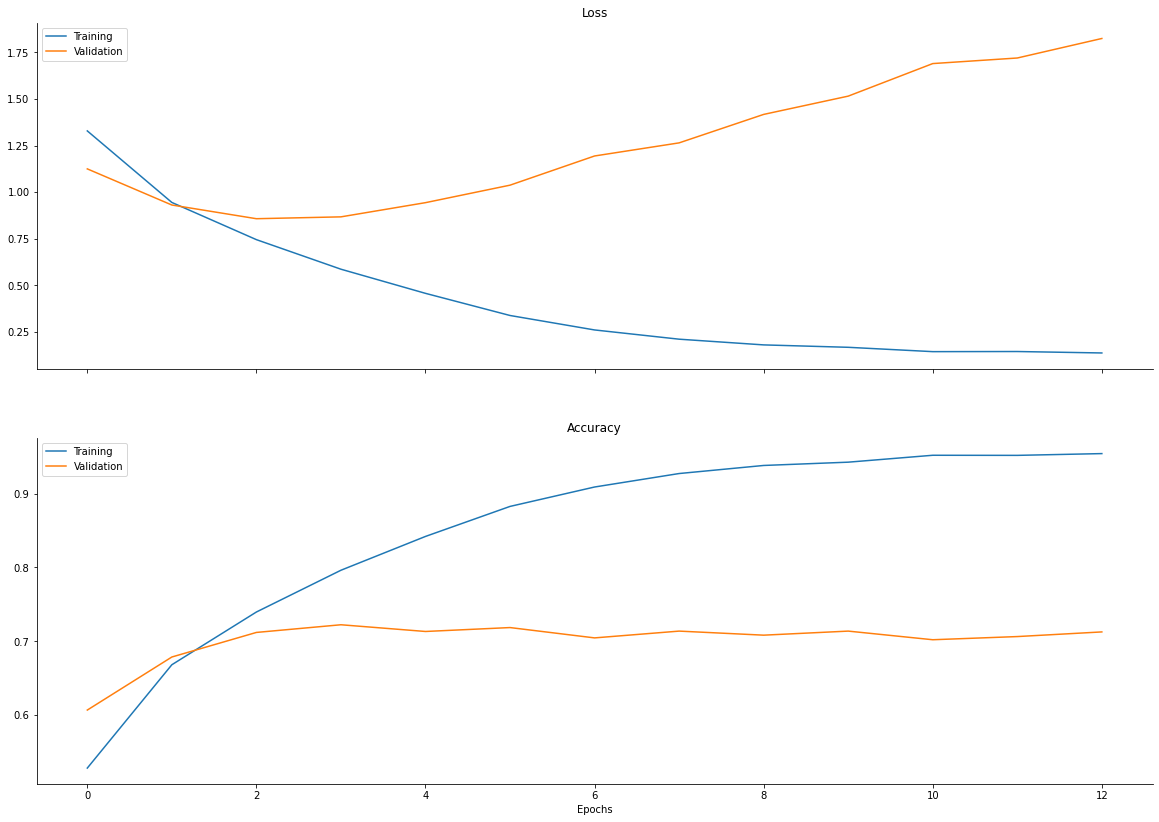

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training(history):

  history = history.history

  fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

  ax1.plot(history['loss'], label='Training')
  ax1.plot(history['val_loss'], label='Validation')
  ax1.legend(loc='best')
  ax1.set_title('Loss')

  ax2.plot(history['acc'], label='Training')
  ax2.plot(history['val_acc'], label='Validation')
  ax2.legend(loc='best')
  ax2.set_title('Accuracy')

  plt.xlabel('Epochs')
  sns.despine()
  plt.show()

plot_training(history)

In [23]:
def print_metrics():
  model.load_weights(filepath)
  metrics = model.evaluate(test_images, test_labels, verbose=0)
  print('Loss = ' + str(metrics[0]))
  print('Accuracy = ' + str(metrics[1]))
  accuracies.append(metrics[1])

print_metrics()

Loss = 0.8567730188369751
Accuracy = 0.7117999792098999


# Tune Dropout

In [26]:
from tensorflow.keras.layers import Dropout

def build_hypermodel(hp):
  inp = Input(shape=(32, 32, 3), name='inp')
  x = Conv2D(32, 3, activation='elu')(inp)
  x = MaxPool2D()(x)
  x = Conv2D(64, 3, activation='elu')(x)
  x = MaxPool2D()(x)
  x = Conv2D(128, 3, activation='elu')(x)
  x = MaxPool2D()(x)
  x = Flatten()(x)
  dp = hp.Float('dp_1', min_value=0.0, max_value=0.2, step=0.1)
  x = Dropout(dp)(x)
  x = Dense(256, activation='swish')(x)
  out = Dense(10, activation='softmax')(x)

  model = Model(inputs=[inp], outputs=[out])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                metrics=['acc'])

  return model

In [27]:
tuner = tune()

INFO:tensorflow:Oracle triggered exit


In [28]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(f"""
The hyperparameter search is complete. The optimal dropout size is {best_hps.get('dp_1')}.
""")


The hyperparameter search is complete. The optimal dropout size is 0.4801627072938893.



In [29]:
model = tuner.hypermodel.build(best_hps)


In [30]:
history = train(model)

Epoch 1/200
1563/1563 - 5s - loss: 1.4531 - acc: 0.4766 - val_loss: 1.1891 - val_acc: 0.5812
Epoch 2/200
1563/1563 - 5s - loss: 1.1533 - acc: 0.5932 - val_loss: 1.0566 - val_acc: 0.6275
Epoch 3/200
1563/1563 - 5s - loss: 1.0232 - acc: 0.6421 - val_loss: 0.9024 - val_acc: 0.6841
Epoch 4/200
1563/1563 - 5s - loss: 0.9388 - acc: 0.6702 - val_loss: 0.8764 - val_acc: 0.6953
Epoch 5/200
1563/1563 - 5s - loss: 0.8748 - acc: 0.6943 - val_loss: 0.8392 - val_acc: 0.7162
Epoch 6/200
1563/1563 - 5s - loss: 0.8348 - acc: 0.7074 - val_loss: 0.7966 - val_acc: 0.7218
Epoch 7/200
1563/1563 - 6s - loss: 0.7905 - acc: 0.7225 - val_loss: 0.7958 - val_acc: 0.7274
Epoch 8/200
1563/1563 - 5s - loss: 0.7603 - acc: 0.7330 - val_loss: 0.7759 - val_acc: 0.7291
Epoch 9/200
1563/1563 - 5s - loss: 0.7295 - acc: 0.7449 - val_loss: 0.7662 - val_acc: 0.7348
Epoch 10/200
1563/1563 - 5s - loss: 0.6990 - acc: 0.7544 - val_loss: 0.7616 - val_acc: 0.7420
Epoch 11/200
1563/1563 - 5s - loss: 0.6793 - acc: 0.7634 - val_loss: 

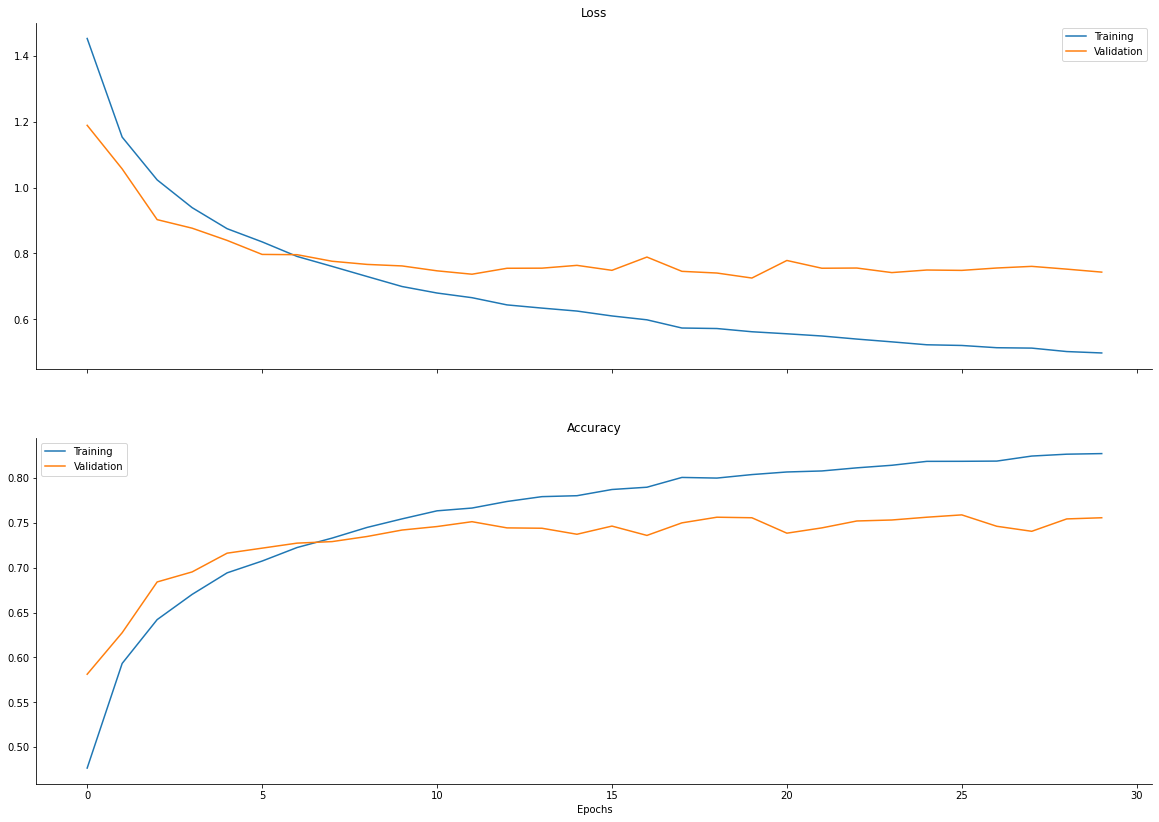

In [31]:
plot_training(history)

In [32]:
print_metrics()

Loss = 0.7248120903968811
Accuracy = 0.7556999921798706


# Tune Image Augmentation

In [37]:
def build_hypermodel(hp):
  inp = Input(shape=(32, 32, 3), name='inp')
  f1 = hp.Float('f1', min_value=0.1, max_value=0.2, step=0.05)
  x = tf.keras.layers.experimental.preprocessing.RandomRotation(f1)(inp)
  x = Conv2D(32, 3, activation='elu')(x)
  x = MaxPool2D()(x)
  x = Conv2D(64, 3, activation='elu')(x)
  x = MaxPool2D()(x)
  x = Conv2D(128, 3, activation='elu')(x)
  x = MaxPool2D()(x)
  x = Flatten()(x)
  x = Dense(256, activation='swish')(x)
  out = Dense(10, activation='softmax')(x)

  model = Model(inputs=[inp], outputs=[out])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                metrics=['acc'])

  return model

In [38]:
tuner = tune()

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [39]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(f"""
The hyperparameter search is complete. The optimal rotation factor is {best_hps.get('f1')}.
""")


The hyperparameter search is complete. The optimal rotation factor is 0.1.



Epoch 1/200
1563/1563 - 7s - loss: 1.5030 - acc: 0.4613 - val_loss: 1.2415 - val_acc: 0.5647
Epoch 2/200
1563/1563 - 7s - loss: 1.2055 - acc: 0.5744 - val_loss: 1.0459 - val_acc: 0.6306
Epoch 3/200
1563/1563 - 7s - loss: 1.0768 - acc: 0.6222 - val_loss: 1.0994 - val_acc: 0.6270
Epoch 4/200
1563/1563 - 7s - loss: 0.9848 - acc: 0.6553 - val_loss: 0.9623 - val_acc: 0.6667
Epoch 5/200
1563/1563 - 7s - loss: 0.9138 - acc: 0.6810 - val_loss: 0.9629 - val_acc: 0.6816
Epoch 6/200
1563/1563 - 7s - loss: 0.8553 - acc: 0.7009 - val_loss: 0.8927 - val_acc: 0.6989
Epoch 7/200
1563/1563 - 7s - loss: 0.8132 - acc: 0.7168 - val_loss: 0.9237 - val_acc: 0.6990
Epoch 8/200
1563/1563 - 7s - loss: 0.7755 - acc: 0.7285 - val_loss: 0.8635 - val_acc: 0.7137
Epoch 9/200
1563/1563 - 7s - loss: 0.7430 - acc: 0.7407 - val_loss: 0.8691 - val_acc: 0.7178
Epoch 10/200
1563/1563 - 7s - loss: 0.7190 - acc: 0.7490 - val_loss: 0.8943 - val_acc: 0.7107
Epoch 11/200
1563/1563 - 7s - loss: 0.6946 - acc: 0.7594 - val_loss: 

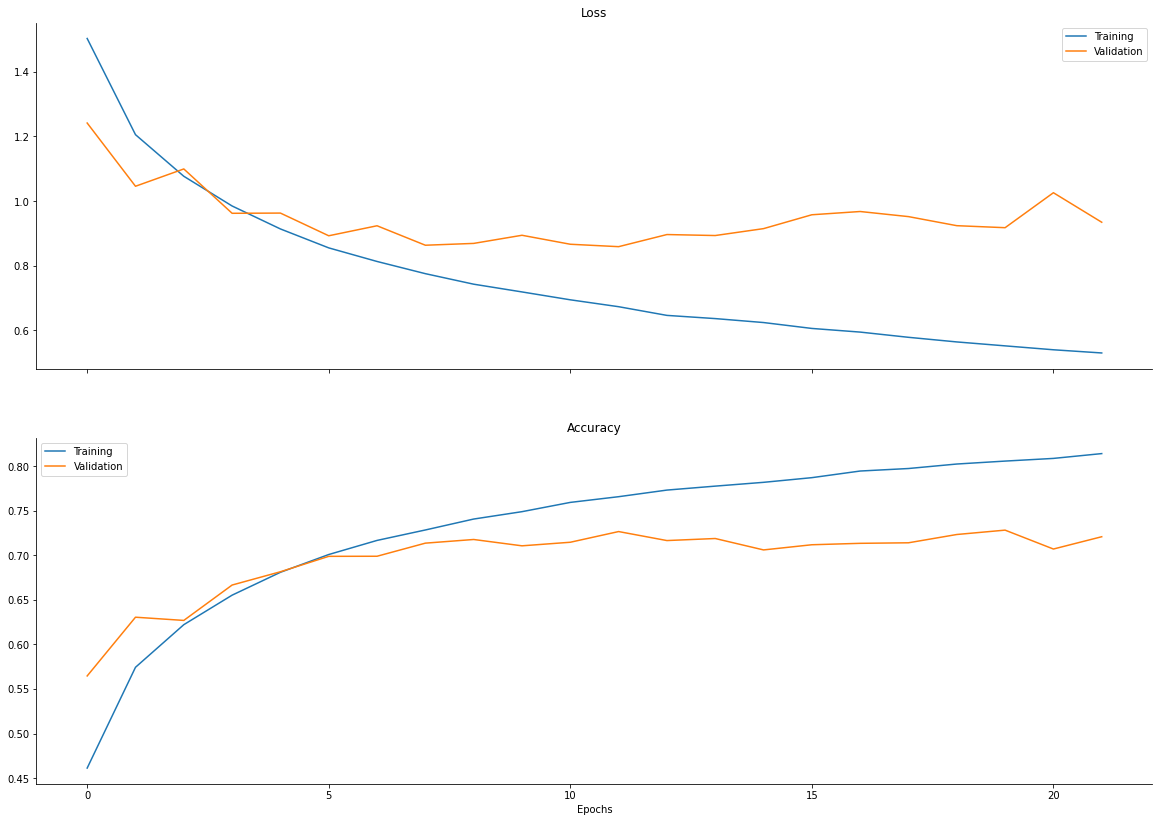

In [40]:
model = tuner.hypermodel.build(best_hps)
history = train(model)
plot_training(history)

In [41]:
print_metrics()

Loss = 0.8590092062950134
Accuracy = 0.7267000079154968


# Results

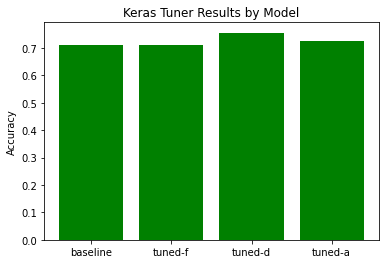

In [42]:
labels = ['baseline', 'tuned-f', 'tuned-d', 'tuned-a']

x_pos = [i for i, _ in enumerate(labels)]

plt.bar(x_pos, accuracies, color='green')
plt.ylabel("Accuracy")
plt.title("Keras Tuner Results by Model")

plt.xticks(x_pos, labels)

plt.show()